# Project 2: Finding Fraud

## Load Libraries

In [27]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules
from sklearn.model_selection import train_test_split    #- partition train/test split
from sklearn.ensemble import RandomForestClassifier     #- random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier
from sklearn.neural_network import MLPClassifier        #- multi-layer perceptron

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# -- need this to render charts in notebook --
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Import Data/Open Zips

In [28]:
url = 'https://raw.githubusercontent.com/MikeVej/MachineLearning_FraudDetection/Model-Code/Data_CSV/project_2_training.csv'
df_train = pd.read_csv(url)

df_train.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,2608000,5774.00000,2172.00000,78.00000,4523.00000,81.237.240.91,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...,graves.org,456-910-9478,South Angelaville,...,R,2021-02-21 16:32:23,Kristi Bell,7683 Chavez Curve,882-35-3409,es_VE,Q,82.00000,4609.00000,legit
1,214500,5405.00000,2887.00000,51.00000,4057.00000,160.32.216.178,Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...,howard-madden.com,269.363.8079,Lake Leslietown,...,O,2020-12-30 11:36:17,Amanda Bond,628 Cline Streets,453-93-1357,bhb_IN,S,2.00000,12384.00000,legit
2,294600,6570.00000,2887.00000,56.00000,5602.00000,109.156.235.28,Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...,walsh-goodwin.com,366.185.9975,Lake Kendra,...,C,2021-03-24 05:34:28,Joanna Walton,268 Ashley Plaza Apt. 416,554-51-8940,mi_NZ,W,43.00000,9607.00000,legit
3,477060,3865.00000,1591.00000,58.00000,3926.00000,158.152.249.45,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,gonzalez-diaz.com,816-365-8213,East Maryport,...,G,2021-10-12 16:24:49,Matthew Johnson,8377 Jacob Course,492-66-7677,yue_HK,Y,71.00000,10305.00000,legit
4,1993100,6625.00000,3297.00000,70.00000,6675.00000,167.164.91.31,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,bender-rocha.info,001-970-935-1735x19620,Yorkburgh,...,W,2021-06-23 00:05:15,Susan Phillips,401 Christopher Meadows,468-86-6030,gd_GB,Q,52.00000,4139.00000,legit


In [29]:
url1 = 'https://raw.githubusercontent.com/MikeVej/MachineLearning_FraudDetection/Model-Code/Data_CSV/project_2_holdout.csv'
# Load the dataset
df_holdout = pd.read_csv(url1)

# Display the first few rows of the dataframe
df_holdout.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount
0,109420,4462,3648,54,6325,197.108.209.59,Opera/8.29.(X11; Linux i686; mk-MK) Presto/2.9...,perez-smith.org,+1-776-557-7526x274,Danielville,...,D,G,3/28/21 22:17,Mrs. Dawn Murray,414 Gregory Mountains Suite 443,618-52-2474,gd_GB,O,23.00000,2422.00000
1,1049060,3360,2180,54,4030,178.166.190.20,Opera/8.16.(X11; Linux i686; is-IS) Presto/2.9...,morris-diaz.com,001-427-310-1481x093,Thompsonshire,...,D,F,5/29/21 6:26,William Hughes,67405 Higgins Ways,651-14-8114,iu_CA,U,58.00000,2160.00000
2,2805320,4725,2063,60,4372,163.48.86.34,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,campos-brown.net,073.152.2261,North Lisaburgh,...,U,Z,3/17/21 7:35,Jennifer Johnson,41514 Toni Junction Suite 866,824-13-0148,yue_HK,O,34.00000,14474.00000
3,450840,5336,2319,72,4385,55.233.5.10,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 1...,hanna-taylor.com,835-295-8283x42594,Joelville,...,X,W,4/26/21 5:34,Brenda Hopkins,1991 Angela Falls,633-56-8621,sa_IN,Y,84.00000,13297.00000
4,423160,6115,3413,61,5942,119.228.12.223,Opera/8.21.(X11; Linux i686; cv-RU) Presto/2.9...,gregory.com,424.203.8183,Hallburgh,...,D,W,1/17/21 13:25,Patricia Davis,57145 Walton Valleys Suite 250,636-15-1188,doi_IN,I,89.00000,5425.00000


## Exploratory Data Analysis:

### Postal Code

In [83]:
#Postal codes where fraud incidents are > 30
pivot_df = df_train.pivot_table(index='billing_postal', columns='EVENT_LABEL', aggfunc='size', fill_value=0)
df_postal_count = df_train.groupby(['billing_postal'])['EVENT_ID'].count().to_frame()
postal_list = list(df_postal_count[df_postal_count['EVENT_ID']>=30].index)

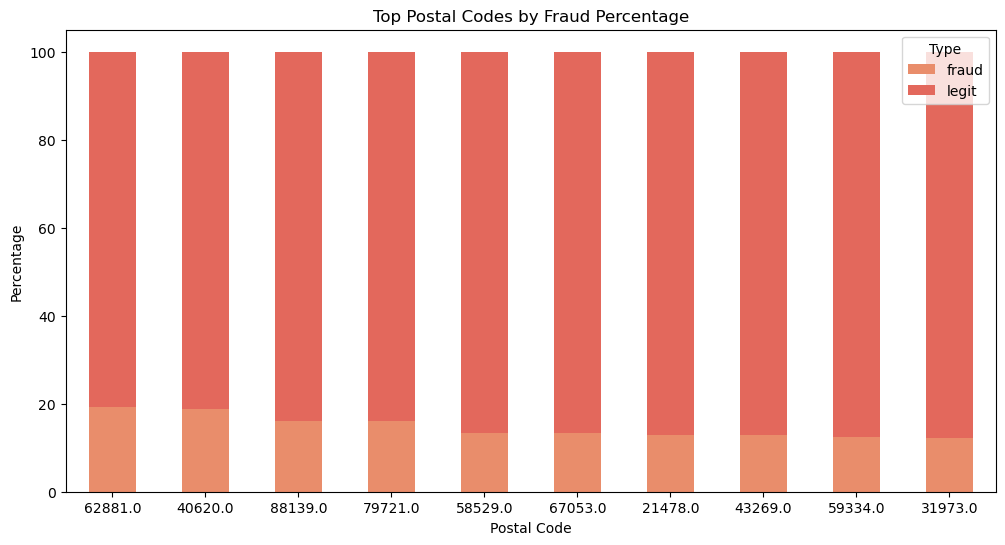

In [88]:
pivot_df.reset_index()
# Calculate percentages
pivot_percentage = pivot_df[['fraud', 'legit']].div(pivot_df[['fraud', 'legit']].sum(axis=1), axis=0) * 100
pivot_percentage = pivot_percentage.sort_values('fraud',ascending=False)
df_viz = pivot_percentage[pivot_percentage.index.isin(postal_list)]

#Plot
sns.set_palette("flare")
df_viz.head(10).plot(kind='bar', stacked=True, grid=False, figsize=(12, 6))
plt.title('Top Postal Codes by Fraud Percentage')
plt.xlabel('Postal Code')
plt.ylabel('Percentage')
plt.legend(title='Type')
plt.xticks(rotation=0)
plt.show()

### Email Domain

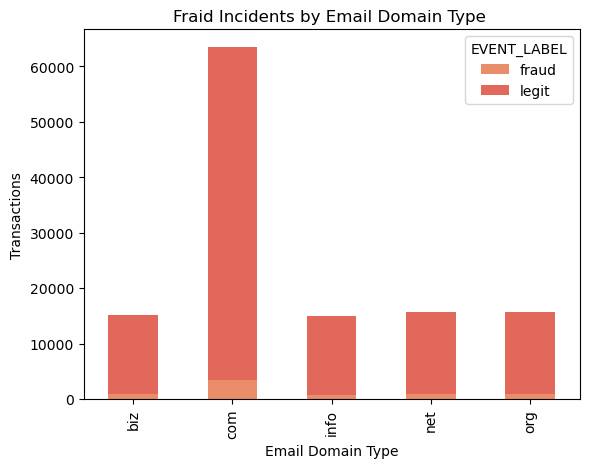

In [90]:
#Plot Fraud Incidents by Email Domain
df_pivot = df_train.pivot_table(index='email_domain_type', columns='EVENT_LABEL', aggfunc='size', fill_value=0)
df_pivot.plot.bar(stacked=True, grid=False)
plt.xlabel('Email Domain Type')
plt.ylabel('Transactions')
plt.title('Fraid Incidents by Email Domain Type ')
plt.show()

### Correlation Matrix

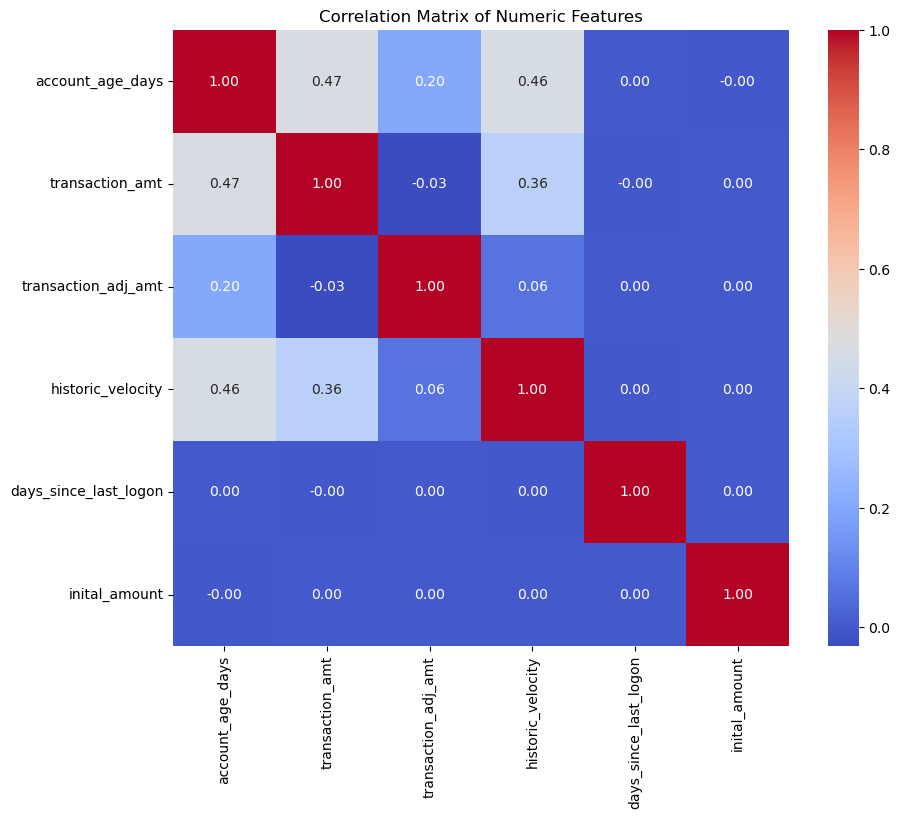

In [98]:
# Compute the correlation matrix
corr = df_train[numerical_cols].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### Numerical Variable Distributions (account age, transaction amount, historic velocity)

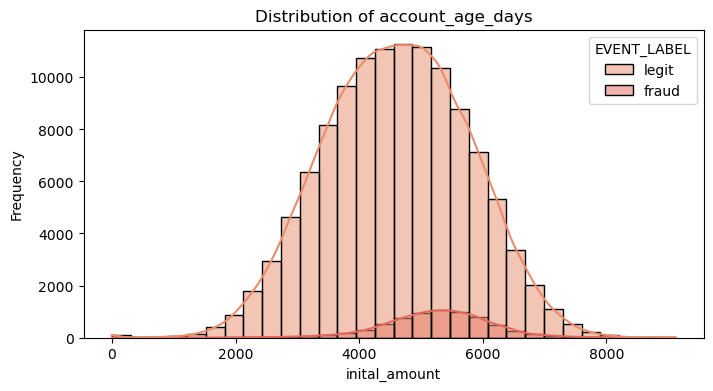

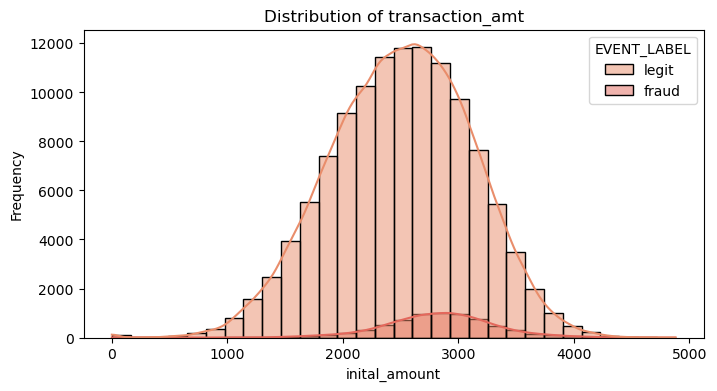

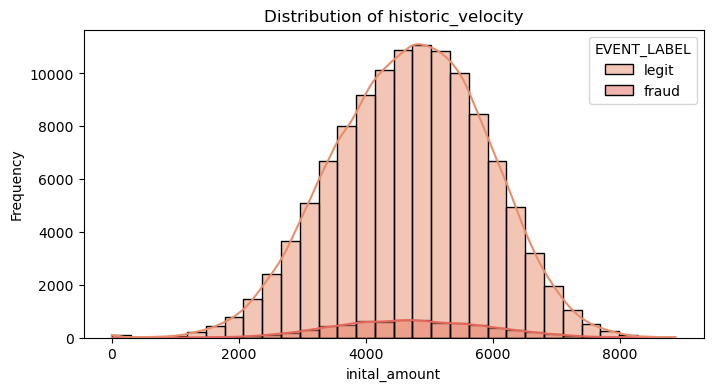

In [100]:
plt.figure(figsize=(8, 4))
sns.histplot(data= df_train, x='account_age_days', hue="EVENT_LABEL", kde=True, bins=30)
plt.title(f'Distribution of account_age_days')
plt.xlabel('account_age_days')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data= df_train, x='transaction_amt', hue="EVENT_LABEL", kde=True, bins=30)
plt.title(f'Distribution of transaction_amt')
plt.xlabel('transaction_amt')
plt.ylabel('Frequency')
plt.show()
    
plt.figure(figsize=(8, 4))
sns.histplot(data= df_train, x='historic_velocity', hue="EVENT_LABEL", kde=True, bins=30)
plt.title(f'Distribution of historic_velocity')
plt.xlabel('historic_velocity')
plt.ylabel('Frequency')
plt.show()

## Data Clean-up (for both Train and Holdout set):

In [32]:
# Clean up email column to only get the domain
# clean train set
df_train['email_domain_type'] = df_train['email_domain'].str.split('.').str[-1]

# clean holdout set
df_holdout['email_domain_type'] = df_holdout['email_domain'].str.split('.').str[-1]

## Data Preparation:

### Describe Data (Categorical or Numeric?)

In [33]:
def df_profile(df, target):

    df = df_train.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)

    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

dfp = df_profile(df_train, 'EVENT_LABEL')
dfp

,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,EVENT_ID,int64,125000,125000,1500443.74368,20.00000,2999960.00000,0,125000,0.00000,1.00000,UNKNOWN,"EXCLUDE, GT 90% UNIQUE"
1,account_age_days,float64,125000,6363,4642.45354,-1.00000,9119.00000,0,125000,0.00000,0.05090,NUMERIC,NO WARNING
2,transaction_amt,float64,125000,3641,2519.54538,-1.00000,4880.00000,0,125000,0.00000,0.02913,NUMERIC,NO WARNING
3,transaction_adj_amt,float64,125000,93,54.14210,-1.00000,99.00000,0,125000,0.00000,0.00074,NUMERIC,NO WARNING
4,historic_velocity,float64,125000,6633,4699.90033,-1.00000,8875.00000,0,125000,0.00000,0.05306,NUMERIC,NO WARNING
5,inital_amount,float64,124891,13999,7999.64274,1000.00000,15000.00000,109,124891,0.00087,0.11199,NUMERIC,NO WARNING
6,days_since_last_logon,float64,124887,101,49.81432,0.00000,100.00000,113,124887,0.00090,0.00081,NUMERIC,NO WARNING
7,billing_postal,float64,124902,11064,50210.79106,503.00000,99950.00000,98,124902,0.00078,0.08851,NUMERIC,NO WARNING
8,card_bin,float64,124890,6321,41813.29049,6040.00000,67639.00000,110,124890,0.00088,0.05057,NUMERIC,NO WARNING
9,tranaction_initiate,object,124900,26,NaN,NaN,NaN,100,124900,0.00080,0.00021,CATEGORY,NO WARNING


In [35]:
# Make postal codes a category type

# Clean train set
df_train['billing_postal'] = df_train['billing_postal'].astype('category')

#clean holdout set
df_holdout['billing_postal'] = df_holdout['billing_postal'].astype('category')

### Split Features

In [36]:
numeric_features =  dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
print(numeric_features)
categorical_features = numeric_features = dfp.query('feature_type == "CATEGORICAL"')['feature_name'].to_list()
print(categorical_features)

['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'inital_amount', 'days_since_last_logon', 'billing_postal', 'card_bin']
[]


### Preprocess Cat./Num Columns

In [37]:
categorical_cols = ['tranaction_initiate', 'transaction_env', 'currency', 
                    'signature_image', 'cvv', 'billing_state', 'transaction_type', 'email_domain_type']

numerical_cols = ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity',
                  'days_since_last_logon', 'billing_postal', 'inital_amount']
feature_names = categorical_cols + numerical_cols
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

### Define Target Variable

In [38]:
# Define the target variable
y = df_train['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})  # Convert to binary
X = df_train.drop('EVENT_LABEL', axis=1)

### Split Data into Train/Test Set

In [39]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)


## Baseline Model - Logistic Reg:

#### LogReg Pipeline/Train

In [40]:
# Define the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=0, max_iter=300))])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'billing_postal',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'transaction_env',
                                                   'currency',
                                                   'signature_image', 'cvv',
                                                   'billing_state',
                                                   'transaction_type',
                                                   'email_domain_type'])])),
                ('classifier',
                 LogisticRegression(max_iter=300, random_state=0))])

#### Create Model Predictions and Accuracy

In [41]:
# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test)
lr_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1]


print("Baseline Logistic Model Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, lr_predictions):.3f}")
print(f"  AUC: {roc_auc_score(y_test, lr_pred_proba):.3f}")
print(f"  Precision: {precision_score(y_test, lr_predictions):.3f}")

Baseline Logistic Model Evaluation:
  Accuracy: 0.975
  AUC: 0.942
  Precision: 0.885


## Model 1 - RandomForest:

#### Baseline RF:

##### Train Baseline Model

In [44]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100,
                                                                    max_depth=10,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'billing_postal',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'transaction_env',
                                                   'currency',
                                                   'signature_image', 'cvv',
                                                   'billing_state',
                                                   'transaction_type',
                                                   'email_domain_type'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_jobs=-1,
                                        random_state=42))])

### Optimized Random Forest:

##### Finding best parameters

In [45]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [30, 50, 100, 150],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [ 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters:
  classifier__max_depth: None
  classifier__min_samples_leaf: 2
  classifier__min_samples_split: 10
  classifier__n_estimators: 150


##### Results of CV

In [46]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,18.52700,3.14464,4.06300,1.33704,None,1,5,30,"{'classifier__max_depth': None, 'classifier__m...",0.94055,0.94117,0.93843,0.94005,0.00117,24
1,21.86667,1.57493,3.69666,0.24745,None,1,5,50,"{'classifier__max_depth': None, 'classifier__m...",0.94346,0.94152,0.94030,0.94176,0.00130,21
2,37.13034,2.62730,6.43500,0.65397,None,1,5,100,"{'classifier__max_depth': None, 'classifier__m...",0.94430,0.94285,0.94389,0.94368,0.00061,14
3,60.93769,1.86563,4.73067,0.46517,None,1,5,150,"{'classifier__max_depth': None, 'classifier__m...",0.94542,0.94364,0.94391,0.94432,0.00078,9
4,18.33234,1.48319,5.56201,0.47726,None,1,10,30,"{'classifier__max_depth': None, 'classifier__m...",0.93998,0.94444,0.94108,0.94184,0.00190,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,8.18200,0.05550,1.42100,0.10885,10,4,5,150,"{'classifier__max_depth': 10, 'classifier__min...",0.93198,0.93392,0.92922,0.93171,0.00193,26
68,4.21433,1.21303,1.37500,0.10837,10,4,10,30,"{'classifier__max_depth': 10, 'classifier__min...",0.92891,0.93027,0.92368,0.92762,0.00284,45
69,2.68633,0.21237,2.52233,0.85382,10,4,10,50,"{'classifier__max_depth': 10, 'classifier__min...",0.92870,0.93094,0.92552,0.92839,0.00223,42
70,5.83600,0.82779,2.88533,0.79957,10,4,10,100,"{'classifier__max_depth': 10, 'classifier__min...",0.93024,0.93403,0.92740,0.93056,0.00271,33


##### Best Parameters

In [48]:
best_params

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 150}

##### Refit with Best Parameters

In [49]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
rf_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=150,
                                                                    min_samples_split=10,
                                                                    min_samples_leaf=2,
                                                                    max_depth = None,
                                                                    n_jobs=-1,
                                                                    random_state=42))])
# Train the pipeline
rf_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'billing_postal',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'transaction_env',
                                                   'currency',
                                                   'signature_image', 'cvv',
                                                   'billing_state',
                                                   'transaction_type',
                                                   'email_domain_type'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

## Model 2 - (GBM):

#### Baseline GBM:

##### Train Baseline Model

In [50]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(
                                                                        learning_rate=0.1, n_estimators=100,
                                                                    ))])
# Train the pipeline
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'billing_postal',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'transaction_env',
                                                   'currency',
                                                   'signature_image', 'cvv',
                                                   'billing_state',
                                                   'transaction_type',
                                                   'email_domain_type'])])),
                ('classifier', GradientBoostingClassifier())])

#### Optimized GBM:

##### Find best parameters

In [51]:
# Create the parameter grid
param_grid = {
    'classifier__n_estimators': [100,150,200,250],
    'classifier__learning_rate': [0.05, 0.1,.15, 0.2],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(gbm_pipeline, param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best set of hyperparameters
best_params = grid_search.best_params_

# Print the best set of hyperparameters
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters:
  classifier__learning_rate: 0.2
  classifier__n_estimators: 250


##### Result of CV

In [52]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,35.31700,5.66174,0.46733,0.25763,0.05000,100,"{'classifier__learning_rate': 0.05, 'classifie...",0.92449,0.92852,0.93042,0.92781,0.00247,16
1,41.72200,7.99678,0.16067,0.02496,0.05000,150,"{'classifier__learning_rate': 0.05, 'classifie...",0.93210,0.93486,0.93504,0.93400,0.00135,15
2,70.54033,7.34114,0.48667,0.22858,0.05000,200,"{'classifier__learning_rate': 0.05, 'classifie...",0.93612,0.93849,0.93876,0.93779,0.00119,13
3,76.99600,11.02612,0.19167,0.00591,0.05000,250,"{'classifier__learning_rate': 0.05, 'classifie...",0.93824,0.94059,0.94049,0.93978,0.00108,12
4,28.00333,4.25217,0.14100,0.01589,0.10000,100,"{'classifier__learning_rate': 0.1, 'classifier...",0.93581,0.93839,0.93916,0.93779,0.00143,14


##### Best parameters

In [53]:
best_params

{'classifier__learning_rate': 0.2, 'classifier__n_estimators': 250}

##### Refit Model w/ new Parameters

In [54]:
# Initialize the pipeline with the preprocessor and a Random Forest classifier
gbm_pipeline_hpo = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(n_estimators=250,
                                                                    learning_rate=0.2,
                                                                    ))])
# Train the pipeline
gbm_pipeline_hpo.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'transaction_adj_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'billing_postal',
                                                   'inital_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tranaction_initiate',
                                                   'transaction_env',
                                                   'currency',
                                                   'signature_image', 'cvv',
                                                   'billing_state',
                                                   'transaction_type',
                                                   'email_domain_type'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2,
                                            n_estimators=250))])

## Performance of Models:

#### Accuracy, AUC, Precision (All 3 Models)

In [69]:
# Make Predictions on models

# Evaluate baseline model
lr_predictions = lr_pipeline.predict(X_test)
lr_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1]

# compare RF baseline model to Hyper Paramter Optimized model
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

y_pred_rf_hpo = rf_pipeline_hpo.predict(X_test)
y_pred_proba_rf_hpo = rf_pipeline_hpo.predict_proba(X_test)[:, 1]

# compare GBM baseline model to Hyper Paramter Optimized model
y_pred_gbm  = gbm_pipeline.predict(X_test)
y_pred_proba_gbm = gbm_pipeline.predict_proba(X_test)[:, 1]

y_pred_gbm_hpo  = gbm_pipeline_hpo.predict(X_test)
y_pred_proba_gbm_hpo = gbm_pipeline_hpo.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("Baseline Logistic Model Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, lr_predictions):.3f}")
print(f"  AUC: {roc_auc_score(y_test, lr_pred_proba):.3f}")
print(f"  Precision: {precision_score(y_test, lr_predictions):.3f}")
print(f"  F1 Score: {precision_score(y_test, lr_predictions):.3f}")
print(f"  Recall: {recall_score(y_test, lr_predictions):.3f}")
print("\n -------- ")

print("Random Forest Baseline Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_rf):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf):.3f}")

print("\n -------- ")
print("Random Forest Optimized Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_rf_hpo):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf_hpo):.4f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_rf_hpo):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf_hpo):.3f}")

print("\n -------- ")
print("GBM Baseline Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm):.3f}")

print("\n -------- ")
print("GBM Optimized Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm_hpo):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm_hpo):.3f}")

Baseline Logistic Model Evaluation:
  Accuracy: 0.975
  AUC: 0.942
  Precision: 0.885
  F1 Score: 0.885
  Recall: 0.623

 -------- 
Random Forest Baseline Evaluation:
  Accuracy: 0.948
  AUC: 0.932
  Precision: 0.980
  F1 Score: 0.980
  Recall: 0.049

 -------- 
Random Forest Optimized Evaluation:
  Accuracy: 0.9734
  AUC: 0.9457
  Precision: 0.9447
  F1 Score: 0.945
  Recall: 0.548

 -------- 
GBM Baseline Evaluation:
  Accuracy: 0.972
  AUC: 0.936
  Precision: 0.881
  F1 Score: 0.881
  Recall: 0.563

 -------- 
GBM Optimized Evaluation:
  Accuracy: 0.979
  AUC: 0.947
  Precision: 0.912
  F1 Score: 0.912
  Recall: 0.690


In [126]:
print("\n -------- ")
print("GBM Baseline Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_gbm):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm):.3f}")

print("\n -------- ")
print("GBM Optimized Evaluation:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_gbm_hpo):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  F1 Score: {precision_score(y_test, y_pred_gbm_hpo):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_gbm_hpo):.3f}")


 -------- 
GBM Baseline Evaluation:
  Accuracy: 0.972
  AUC: 0.936
  Precision: 0.881
  F1 Score: 0.881
  Recall: 0.563

 -------- 
GBM Optimized Evaluation:
  Accuracy: 0.979
  AUC: 0.947
  Precision: 0.912
  F1 Score: 0.912
  Recall: 0.690


#### ROC, Precision-Recall Curve

In [105]:
train, test = train_test_split(df_train,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df_train.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df_train.shape[0]))

train pct: 70.00%
test  pct: 30.00%


#### FPR/TPR/Threshold -

##### Logistic 

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_proba)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.7189, Threshold: 0.3381
Target FPR: 0.02, Expected TPR: 0.7816, Threshold: 0.2148
Target FPR: 0.03, Expected TPR: 0.8053, Threshold: 0.1598
Target FPR: 0.04, Expected TPR: 0.8262, Threshold: 0.1256
Target FPR: 0.05, Expected TPR: 0.8408, Threshold: 0.1032
Target FPR: 0.06, Expected TPR: 0.8529, Threshold: 0.0857
Target FPR: 0.07, Expected TPR: 0.8655, Threshold: 0.0736
Target FPR: 0.08, Expected TPR: 0.8723, Threshold: 0.0639
Target FPR: 0.09, Expected TPR: 0.8796, Threshold: 0.0558
Target FPR: 0.10, Expected TPR: 0.8850, Threshold: 0.0497


In [58]:

# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_Logistic = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_Logistic

,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.71893,0.33810
1,2.00000,0.78155,0.21483
2,3.00000,0.80534,0.15981
3,4.00000,0.82621,0.12557
4,5.00000,0.84078,0.10319
5,6.00000,0.85291,0.08572
6,7.00000,0.86553,0.07360
7,8.00000,0.87233,0.06391
8,9.00000,0.87961,0.05582
9,10.00000,0.88495,0.04973


##### Random Forest

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf_hpo)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.7466, Threshold: 0.2969
Target FPR: 0.02, Expected TPR: 0.8039, Threshold: 0.2075
Target FPR: 0.03, Expected TPR: 0.8277, Threshold: 0.1619
Target FPR: 0.04, Expected TPR: 0.8427, Threshold: 0.1329
Target FPR: 0.05, Expected TPR: 0.8578, Threshold: 0.1116
Target FPR: 0.06, Expected TPR: 0.8709, Threshold: 0.0964
Target FPR: 0.07, Expected TPR: 0.8806, Threshold: 0.0860
Target FPR: 0.08, Expected TPR: 0.8893, Threshold: 0.0766
Target FPR: 0.09, Expected TPR: 0.8971, Threshold: 0.0690
Target FPR: 0.10, Expected TPR: 0.9000, Threshold: 0.0633


In [60]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_rf = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_rf

,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.74660,0.29691
1,2.00000,0.80388,0.20755
2,3.00000,0.82767,0.16188
3,4.00000,0.84272,0.13289
4,5.00000,0.85777,0.11157
5,6.00000,0.87087,0.09638
6,7.00000,0.88058,0.08598
7,8.00000,0.88932,0.07662
8,9.00000,0.89709,0.06902
9,10.00000,0.90000,0.06335


##### GBM 

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gbm_hpo)

# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.7728, Threshold: 0.2696
Target FPR: 0.02, Expected TPR: 0.8150, Threshold: 0.1513
Target FPR: 0.03, Expected TPR: 0.8476, Threshold: 0.1030
Target FPR: 0.04, Expected TPR: 0.8646, Threshold: 0.0771
Target FPR: 0.05, Expected TPR: 0.8757, Threshold: 0.0609
Target FPR: 0.06, Expected TPR: 0.8820, Threshold: 0.0503
Target FPR: 0.07, Expected TPR: 0.8864, Threshold: 0.0439
Target FPR: 0.08, Expected TPR: 0.8932, Threshold: 0.0381
Target FPR: 0.09, Expected TPR: 0.8971, Threshold: 0.0338
Target FPR: 0.10, Expected TPR: 0.9019, Threshold: 0.0302


In [62]:
# Create a DataFrame from the target FPR, interpolated TPR, and interpolated thresholds
target_fpr_df_gbm = pd.DataFrame({
    'Target FPR (%)': target_fpr * 100,  # Convert to percentage
    'Expected TPR': interp_tpr,
    'Threshold': interp_thresholds
})

# Display the DataFrame
target_fpr_df_gbm

,Target FPR (%),Expected TPR,Threshold
0,1.00000,0.77282,0.26963
1,2.00000,0.81505,0.15128
2,3.00000,0.84757,0.10303
3,4.00000,0.86456,0.07709
4,5.00000,0.87573,0.06094
5,6.00000,0.88204,0.05034
6,7.00000,0.88641,0.04388
7,8.00000,0.89320,0.03813
8,9.00000,0.89709,0.03378
9,10.00000,0.90194,0.03016


## Most important Features

### Logistic Features

In [78]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = lr_pipeline.named_steps['classifier'].coef_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance[0]})
feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Logistic Regression coefficients as feature importance
lr_coefficients = lr_pipeline.named_steps['classifier'].coef_[0]

# Aligning feature names and coefficients
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Coefficient', ascending=False)
lr_feature_importance_df.head(10)

,Feature,Coefficient
34,cat__transaction_env_B,3.00300
48,cat__transaction_env_P,2.60188
42,cat__transaction_env_J,2.56799
163,cat__transaction_type_B,2.47949
49,cat__transaction_env_Q,2.46609
88,cat__cvv_B,2.41727
171,cat__transaction_type_J,2.34947
100,cat__cvv_N,2.34199
178,cat__transaction_type_Q,2.04012
71,cat__signature_image_J,1.97734


### Random Forest Features

In [71]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

rf_importances = rf_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
rf_feature_importance_df.head(10)

,Feature,Importance
2,transaction_adj_amt,0.29427
0,account_age_days,0.08501
3,historic_velocity,0.05190
1,transaction_amt,0.04212
6,inital_amount,0.02084
5,billing_postal,0.02035
4,days_since_last_logon,0.01805
61,currency_usd,0.01799
108,cvv_V,0.01787
100,cvv_N,0.01690


### GBM Features

In [76]:
# Adjusting the feature name extraction for OneHotEncoder to use get_feature_names_out
feature_names = list(preprocessor.transformers_[0][2]) + \
    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))

gbm_hpo_importances = gbm_pipeline_hpo.named_steps['classifier'].feature_importances_

# Display the top 10 features
gbm_hpo_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbm_hpo_importances})
gbm_hpo_importance_df = gbm_hpo_importance_df.sort_values(by='Importance', ascending=False)
gbm_hpo_importance_df.head(10)

,Feature,Importance
2,transaction_adj_amt,0.42522
0,account_age_days,0.18561
3,historic_velocity,0.08046
61,currency_usd,0.04482
1,transaction_amt,0.02085
100,cvv_N,0.01959
105,cvv_S,0.01857
108,cvv_V,0.01823
180,transaction_type_S,0.01572
46,transaction_env_N,0.01500


### Features Bar graph

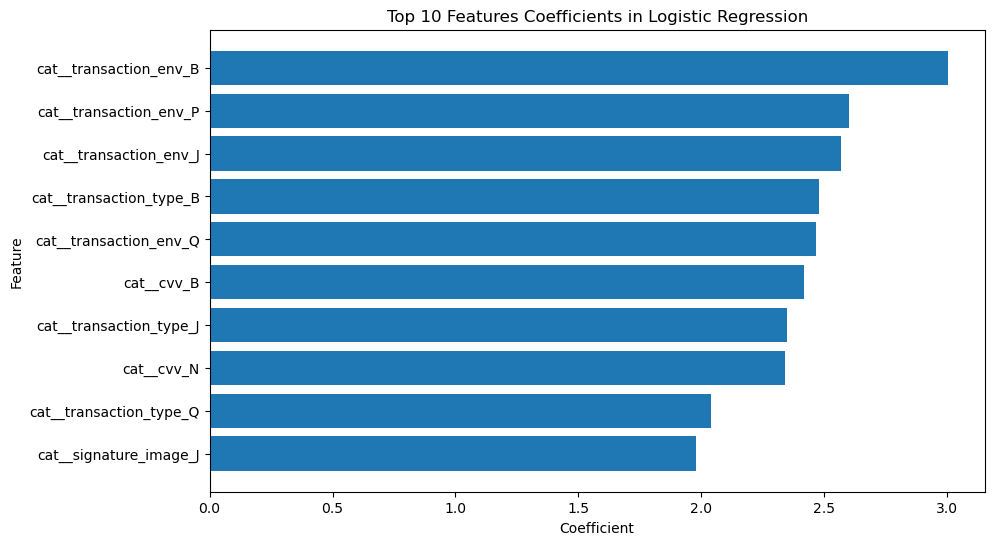

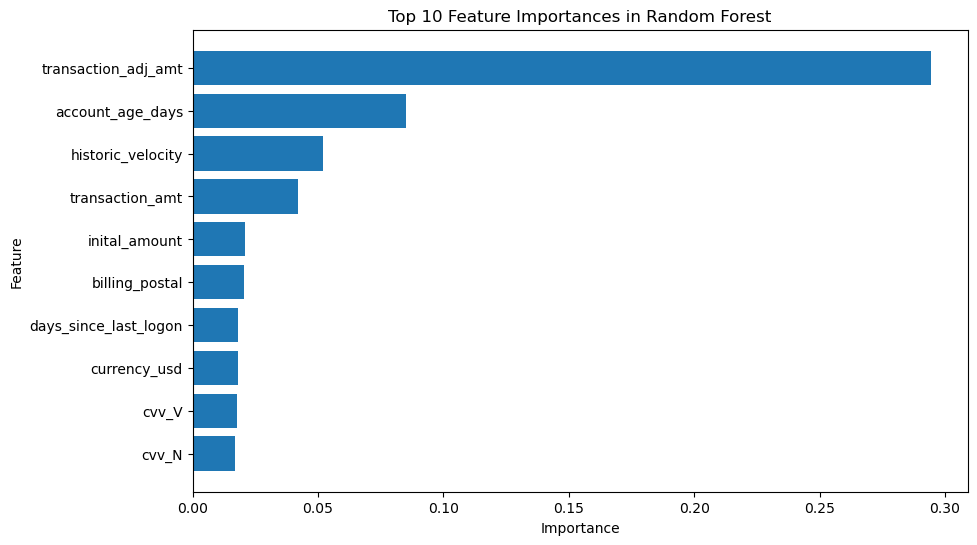

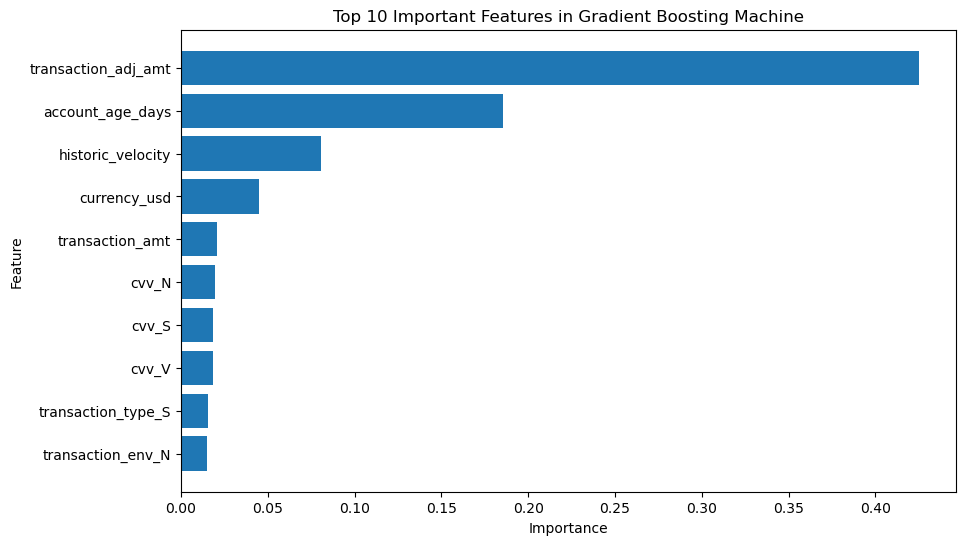

In [80]:
# Plot for Logistic Regression
plt.figure(figsize=(10, 6))
plt.title('Top 10 Features Coefficients in Logistic Regression')
plt.barh(lr_feature_importance_df['Feature'][:10], lr_feature_importance_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances in Random Forest')
plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Plot for GBM HPO Features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features in Gradient Boosting Machine")
plt.barh(gbm_hpo_importance_df['Feature'][:10], gbm_hpo_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

## Test Final Model - Optimized GBM

### Make predictions on model

In [64]:
pred = gbm_pipeline_hpo.predict_proba(df_holdout)[:,1]

In [65]:
df_submission = df_holdout[['EVENT_ID']].copy()
df_submission['EVENT_LABEL'] = pred
df_submission

,EVENT_ID,EVENT_LABEL
0,109420,0.00704
1,1049060,0.00159
2,2805320,0.00696
3,450840,0.00190
4,423160,0.00787
...,...,...
24995,1946880,0.00762
24996,1744520,0.05386
24997,432200,0.08602
24998,1082260,0.00107


##### Extract predictions file

In [81]:
df_submission.to_csv('Project2_Predictions_MichaelVejsiri.csv', index=False)